In [3]:
#install package for visulization
!pip install squarify

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import squarify
from datetime import datetime

In [6]:

data= pd.read_csv('/content/drive/MyDrive/Recommandation_System_dataset/OnlineRetail.csv', encoding='latin-1')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [7]:
#Only take 200000 because my Google Colab couldn't handle 500K
amount= 200000
if amount > 0:
    data= data.iloc[:amount, :]
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [9]:
#View out number of null customer and number of empty Invoice
custID= 'CustomerID'
print(f'Number of Unknown Customer: {data[custID].isnull().sum()}')
print(f'Number of Empty Invoice: {data["InvoiceNo"].isnull().sum()}')

Number of Unknown Customer: 58014
Number of Empty Invoice: 0


In [10]:
#fill null if CustID is false
removeNoneCustomerID= True
if not removeNoneCustomerID:
    data[custID].fillna(-1, inplace= True)
data[custID].value_counts()

,count
CustomerID,
17841.0,1875
14911.0,1556
12748.0,1344
14606.0,1333
15311.0,1166
...,...
16500.0,1
15753.0,1
13841.0,1


In [11]:
#Before and after fill
na_count= data.isna().sum().sum()
if na_count > 0:
    print(f'Before: {na_count} of {len(data)} NA records')
    data= data.dropna()
    print(f'After: {len(data)} records')
else:
    print('No null data')

Before: 58804 of 200000 NA records
After: 141986 records


In [12]:
string_to_date= lambda dt: datetime.strptime(dt, "%d-%m-%Y %H:%M").date()
dtCol= 'InvoiceDate'
data[dtCol]= data[dtCol].apply(string_to_date)
data[dtCol]= data[dtCol].astype('datetime64[ns]')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom


In [13]:
#Adding another columns to Money ( quantity * unit )
MCol= 'Money'
data[MCol]= data.apply(lambda r: r['Quantity']*r['UnitPrice'], axis=1)
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Money
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,20.34


In [14]:
if len(data[data[custID] == -1]) > 0:
    print(f'Revenue from unknown customer without ID: {data[data[custID] == -1][MCol].sum()}')

In [15]:
latestDate= data[dtCol].max().date() # The most recent transaction date
Recency= lambda r: (latestDate - r.max().date()).days # How Recently they purchase
Frequency= lambda r: len(r.unique()) # How often they purchase
Monetary= lambda r: round(sum(r), 2) # How much they spend

# Customer segmentation based on CustomerID to calculate R, F, M
data= data.groupby(custID).agg({dtCol: Recency, 'InvoiceNo': Frequency, MCol: Monetary}).reset_index()
data

,CustomerID,InvoiceDate,InvoiceNo,Money
0,12346.0,124,2,0.00
1,12347.0,45,3,1823.43
2,12348.0,47,3,1487.24
3,12350.0,109,1,334.40
4,12352.0,61,8,601.18
...,...,...,...,...
2702,18273.0,56,1,51.00
2703,18277.0,117,1,-12.75
2704,18280.0,76,1,180.60
2705,18283.0,31,4,435.58


In [16]:
rColName= 'Recency'
fColName= 'Frequency'
mColName= 'Monetary'

data.columns= [custID, rColName, fColName, mColName] # Change name of column
data= data.sort_values(mColName, ascending= False)
data.head()

,CustomerID,Recency,Frequency,Monetary
1066,14646.0,4,24,100295.24
2623,18102.0,5,16,64483.90
32,12415.0,2,9,50290.20
824,14156.0,6,21,41345.98
2322,17450.0,25,12,36576.76


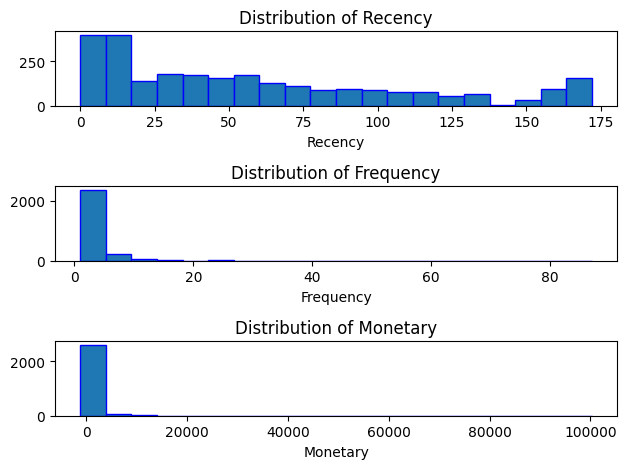

In [17]:
plt.subplot(3, 1, 1)
plt.hist(data[rColName], bins= 20, edgecolor= 'b')
plt.title('Distribution of ' + rColName)
plt.xlabel(rColName)

plt.subplot(3, 1, 2)
plt.hist(data[fColName], bins= 20, edgecolor= 'b')
plt.title('Distribution of ' + fColName)
plt.xlabel(fColName)

plt.subplot(3, 1, 3)
plt.hist(data[mColName], bins= 20, edgecolor= 'b')
plt.title('Distribution of ' + mColName)
plt.xlabel(mColName)

plt.tight_layout()
plt.show()

* Recency : Most customers have a low recency value, indicating that many customers have made recent transactions (as recency is lower). There are fewer customers as the recency value increases, meaning fewer customers who haven’t made a transaction in a long time.
* Frequency : The majority of customers have a very low frequency, often around 1 transaction. There are very few customers with a high frequency of transactions. This is common, as most businesses have a small percentage of very frequent customers.
* Monetary : Most customers have spent relatively low amounts of money. There are fewer customers as the total spending amount increases, indicating a typical distribution where a small number of customers contribute a significant portion of revenue.

In [18]:
RFM_df= data.copy()
RFM_df.shape

(2707, 4)

In [19]:
rLabel= range(4, 0, -1) # Distribute Recency, the longer the time the lower the score
fLabel= range(1, 5) # Distribute Frequency, the more transaction the higher the score
mLabel= range(1, 5) # Distribute Monetary : The more money spend the higher the score

In [20]:
#Store R,F,M into different group
rGroup= pd.qcut(RFM_df[rColName].rank(method= 'first'), q= 4, labels= rLabel)
fGroup= pd.qcut(RFM_df[fColName].rank(method= 'first'), q= 4, labels= fLabel)
mGroup= pd.qcut(RFM_df[mColName].rank(method= 'first'), q= 4, labels= mLabel)

In [21]:

RFM_df= RFM_df.assign(R= rGroup, F= fGroup, M= mGroup)
RFM_df

,CustomerID,Recency,Frequency,Monetary,R,F,M
1066,14646.0,4,24,100295.24,4,4,4
2623,18102.0,5,16,64483.90,4,4,4
32,12415.0,2,9,50290.20,4,4,4
824,14156.0,6,21,41345.98,4,4,4
2322,17450.0,25,12,36576.76,3,4,4
...,...,...,...,...,...,...,...
1794,16252.0,165,1,-295.09,1,2,1
2388,17603.0,66,1,-555.90,2,2,1
1596,15823.0,136,2,-840.76,1,3,1
71,12503.0,136,1,-1126.00,1,2,1


In [ ]:
#View out to see different R,F,M across diff client
rfm_count_unique= RFM_df[['R', 'F', 'M']].value_counts()
rfm_count_unique

R  F  M
4  4  4    265
1  2  1    244
3  4  4    146
1  1  2    143
2  2  1    137
   1  2    125
3  1  2     82
   2  1     79
2  3  2     76
3  3  3     74
4  3  3     73
3  3  2     72
4  4  3     66
2  1  3     60
3  4  3     60
1  3  2     58
2  3  3     53
4  3  2     49
2  4  4     48
1  1  3     48
4  1  2     44
   2  1     37
1  3  3     36
      1     34
2  2  3     34
3  1  3     33
   2  3     32
4  3  4     30
   1  3     29
2  3  1     28
3  3  4     27
2  4  3     25
1  1  1     25
2  3  4     24
   1  1     24
4  2  4     24
      3     23
3  3  1     22
   2  4     22
2  1  4     17
1  2  3     17
2  2  4     16
1  1  4     16
   4  3     13
   2  4     12
4  3  1     12
1  3  4      8
   4  1      8
      2      8
4  1  1      8
3  1  4      8
      1      8
2  4  2      7
4  4  2      7
   1  4      7
1  4  4      7
3  4  2      6
      1      6
4  4  1      3
2  4  1      2
dtype: int64

In [22]:
# Built out customer segmentation
SVIP= ' VIP'
KHTX= 'Lovely Customer'
KHBig= 'Big Spender'
KHMid= 'Middle Class'
KHVL= 'Once a while'
KHVD= 'Nobody'
KHTH= 'return items'
def RFMGrade(df):
    if df[custID] < 0: # Number of client doesnt have ID
        return KHVD
    elif df[mColName] <= 0: #Client who return items
        return KHTH
    elif (df.R >= 3)and(df.F == 4)and(df.M == 4): #The one who spend frequently and spend lots of money
        return SVIP
    elif (df.R >= 3)and(df.F >= 3): #Usually spending money
        return KHTX
    elif (df.M == 4): #The one spend lots of money
        return KHBig
    elif (df.R > 1)and(df.F > 1)and(df.M > 1): # normal customer
        return KHMid
    else:
        return KHVL #Once a while customer

In [23]:
#Grade them in the scale we compute
clusterCol= 'Grade'
RFM_df[clusterCol]= RFM_df.apply(RFMGrade, axis= 1)
RFM_df

,CustomerID,Recency,Frequency,Monetary,R,F,M,Grade
1066,14646.0,4,24,100295.24,4,4,4,VIP
2623,18102.0,5,16,64483.90,4,4,4,VIP
32,12415.0,2,9,50290.20,4,4,4,VIP
824,14156.0,6,21,41345.98,4,4,4,VIP
2322,17450.0,25,12,36576.76,3,4,4,VIP
...,...,...,...,...,...,...,...,...
1794,16252.0,165,1,-295.09,1,2,1,return items
2388,17603.0,66,1,-555.90,2,2,1,return items
1596,15823.0,136,2,-840.76,1,3,1,return items
71,12503.0,136,1,-1126.00,1,2,1,return items


In [24]:
RFM_df[clusterCol].value_counts()

,count
Grade,
Once a while,1272
Lovely Customer,505
VIP,411
Middle Class,250
Big Spender,209
return items,60


In [25]:
#Distribution of each class
rfm_agg= RFM_df.groupby(clusterCol).agg({rColName: 'mean', fColName: 'mean', mColName: ['mean', 'count']})
rfm_agg.columns= rfm_agg.columns.droplevel()
rfm_agg.columns= ['R_mean', 'F_mean', 'M_mean', 'Count']
rfm_agg['Percent']= round(rfm_agg['Count']/rfm_agg['Count'].sum()*100, 2)
rfm_agg.reset_index(inplace= True)
rfm_agg

,Grade,R_mean,F_mean,M_mean,Count,Percent
0,VIP,13.795620,9.581509,4220.822555,411,15.18
1,Big Spender,61.755981,3.071770,1816.008852,209,7.72
2,Lovely Customer,18.966337,3.233663,653.456772,505,18.66
3,Middle Class,54.736000,2.504000,580.392520,250,9.24
4,Once a while,87.323899,1.241352,294.613428,1272,46.99
5,return items,128.133333,1.400000,-99.750833,60,2.22


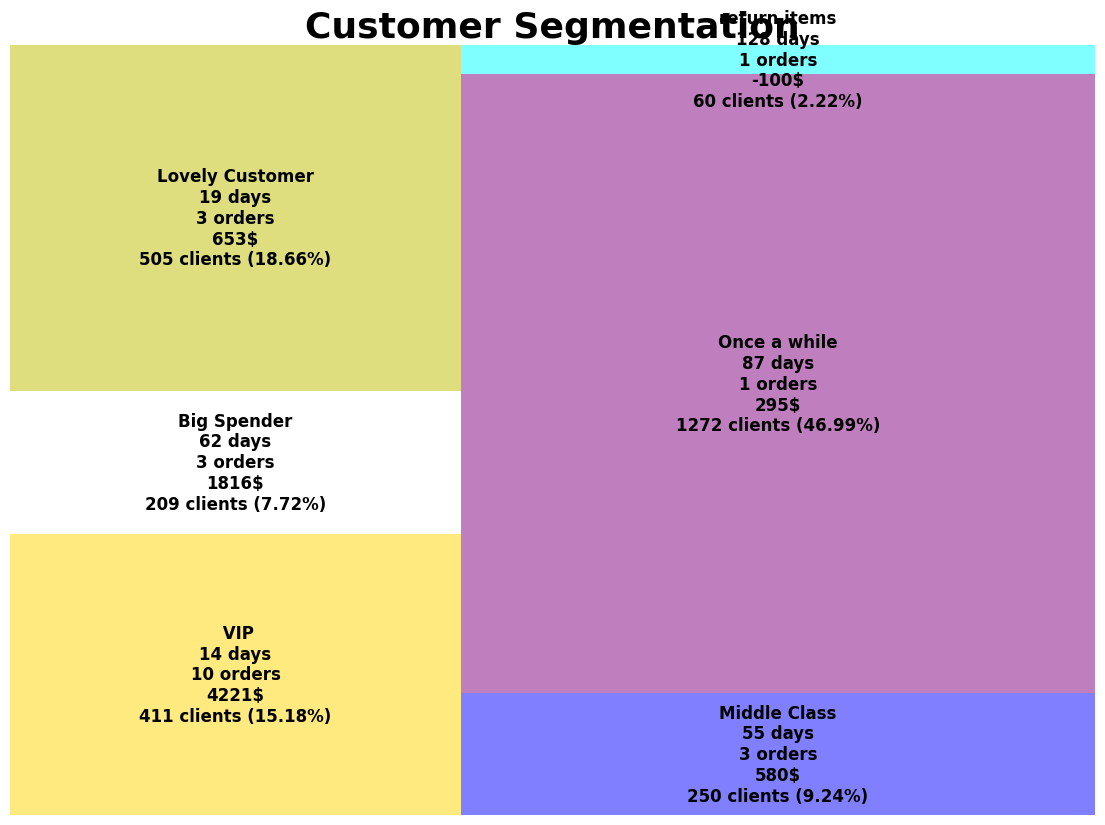

In [26]:
fig= plt.gcf()
ax= fig.add_subplot()
fig.set_size_inches(14, 10)
colorDict= {SVIP: 'gold', KHTX: 'w', KHBig: 'y', KHMid: 'b', KHVL: 'purple', KHVD: 'cyan', KHTH: 'red'}
squarify.plot(sizes= rfm_agg['Count'],
              text_kwargs= {'fontsize': 12, 'weight': 'bold'},
              color= colorDict.values(),
              label=['{}\n{:.0f} days\n{:.0f} orders\n{:.0f}$\n{:.0f} clients ({}%)'.format(*rfm_agg.iloc[i])
                     for i in range(len(rfm_agg))], alpha= 0.5)
plt.title('Customer Segmentation', fontsize= 26, fontweight= 'bold')
plt.axis('off')
plt.show()

In [27]:

import plotly.express as px
fig= px.scatter(rfm_agg, x= 'R_mean', y= 'M_mean', size= 'F_mean', color= clusterCol, hover_name= clusterCol, size_max= 100)
fig.show()

**Note:**

* VIP : This is the most valuable segment with frequent and high spending.They spend around 4K2 $ with an average frequency around 10 order and most recent they purchase is 14 days ago. These customers are the core of the business and should be prioritized for retention, perhaps giving me more benefit like exclusive deal, VIP subscription services, special events for them .

* Big Spender: They are the group spend large lum-sum amount of money but not very frequent. They have a spending average of 1k8$ but the last time they purchased was 62 days ago. We also need to encourage them to spend more by offer discounts, upselling premium products and once a month campain then email to them to remind them about our product.

* Lovely Customer: These customers are fairly regular in their purchase and spend with a moderate amount of money. They spend an average of 653$ and  3 order with 19 days recently active. They have the second largest in the customer base. We should introduce them into loyalty program increase engagement and spending by offering point, recommanding similar project to potentially increase the average orders.

* Middle cLass : These customer are somwhat engaged but likely to become inactive, with an average amount of 580$ ,3 order wand 44 days less recent. Giving discount and bundle offer would be a great choice. Recommand product they liked based on their purchase .

* Once a while : These are the people who has the largest segment but are infrequently buyers with low spending 295$ and 87 days ago. Maybe giving me free discount or "last chance opportunity" to encourage them to comover


* Return items : These are the customer who returned their items with average of 100$ and the last time is 128 days ago. We should address why they want to return the items and offer customer support, considering 5-10% discount if they have a quality reason to built trust.


In [28]:
data

,CustomerID,Recency,Frequency,Monetary
1066,14646.0,4,24,100295.24
2623,18102.0,5,16,64483.90
32,12415.0,2,9,50290.20
824,14156.0,6,21,41345.98
2322,17450.0,25,12,36576.76
...,...,...,...,...
1794,16252.0,165,1,-295.09
2388,17603.0,66,1,-555.90
1596,15823.0,136,2,-840.76
71,12503.0,136,1,-1126.00


In [29]:
#Using K mean
from sklearn.cluster import KMeans
kmean_df= data[[rColName, fColName, mColName]]
sse= {}
for k in range(1, 20):
    kmeans= KMeans(n_clusters= k, random_state= 42)
    kmeans.fit(kmean_df)
    sse[k]= kmeans.inertia_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will 

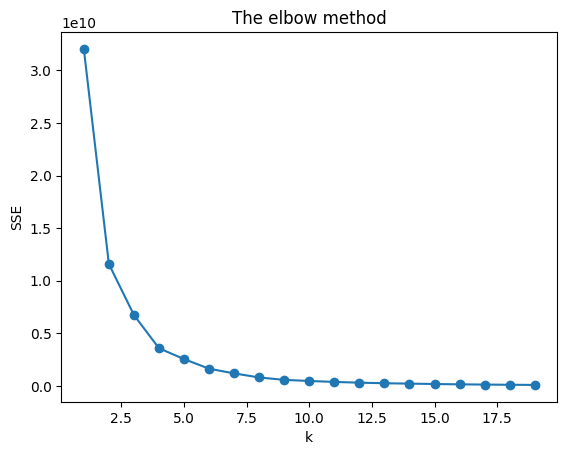

In [30]:
plt.title('The elbow method')
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(list(sse.keys()), list(sse.values()), marker= 'o')
plt.show()

In [31]:
# Chosing K = 5
k= 5
model= KMeans(n_clusters= k, random_state= 42)
model.fit(kmean_df)
model.labels_.shape

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



(2707,)

In [32]:
kmean_df[clusterCol]= model.labels_
kmean_agg= kmean_df.groupby(clusterCol).agg({rColName: 'mean', fColName: 'mean', mColName: ['mean', 'count']})
kmean_agg

Recency  Frequency       Monetary      
            mean       mean           mean count
Grade                                           
0      61.888758   2.487662     627.166251  2553
1      12.384615  30.615385   26918.310000    13
2       4.000000  24.000000  100295.240000     1
3      17.686131  12.284672    5479.212847   137
4       4.333333  15.333333   52040.026667     3

In [33]:
kmean_agg.columns= kmean_agg.columns.droplevel()
kmean_agg.columns= ['R_mean', 'F_mean', 'M_mean', 'Count']
kmean_agg['Percent']= round(kmean_agg['Count']/kmean_agg['Count'].sum()*100, 2)
kmean_agg.reset_index(inplace= True)
kmean_agg

,Grade,R_mean,F_mean,M_mean,Count,Percent
0,0,61.888758,2.487662,627.166251,2553,94.31
1,1,12.384615,30.615385,26918.310000,13,0.48
2,2,4.000000,24.000000,100295.240000,1,0.04
3,3,17.686131,12.284672,5479.212847,137,5.06
4,4,4.333333,15.333333,52040.026667,3,0.11


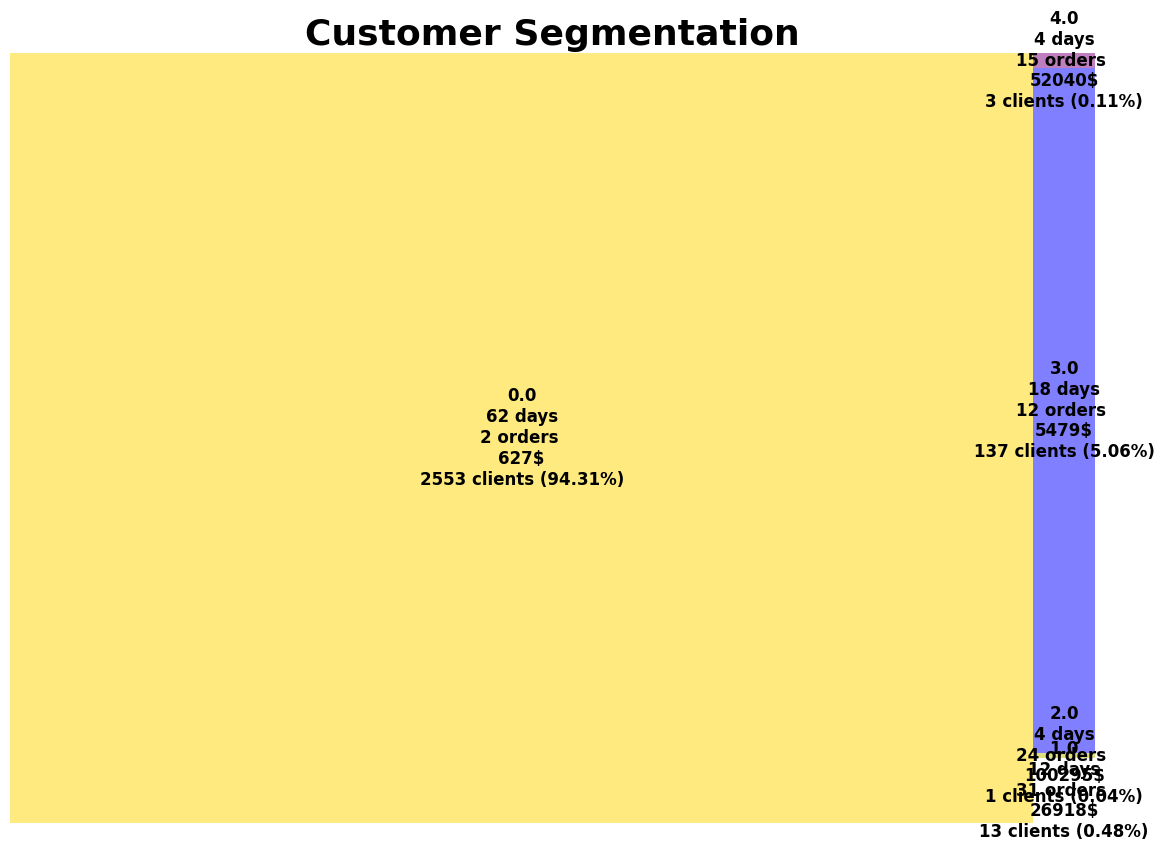

In [36]:
fig= plt.gcf()
ax= fig.add_subplot()
fig.set_size_inches(14, 10)
colorDict= {SVIP: 'gold', KHTX: 'w', KHBig: 'y', KHMid: 'b', KHVL: 'purple', KHVD: 'cyan', KHTH: 'red'}
squarify.plot(sizes= kmean_agg['Count'],
              text_kwargs= {'fontsize': 12, 'weight': 'bold'},
              color= colorDict.values(),
              label=['{}\n{:.0f} days\n{:.0f} orders \n{:.0f}$\n{:.0f} clients ({}%)'.format(*kmean_agg.iloc[i])
                     for i in range(len(kmean_agg))], alpha= 0.5)
plt.title('Customer Segmentation', fontsize= 26, fontweight= 'bold')
plt.axis('off')
plt.show()

In [37]:
import plotly.express as px
fig= px.scatter(kmean_agg, x= 'R_mean', y= 'M_mean', size= 'F_mean', color= clusterCol, hover_name= clusterCol, size_max= 100)
fig.show()

After using K-mean to cluster the data again we have:

* Grade 0: Which is the largest segmentation with 94% customer base with an average of 627$ , 2.5 orders and the most recent is 2 months ago. We should focus on re-engagement. Consider sending targeted campaigns, offering discounts or promotions to encourage repeat purchases, and educating them about new products.

* Grade 1:They are high value, frequent customer consider VIP with 26K$ average , 30 orders and the last day is 12 days ago. Maintain and deepen the relationship. Offer exclusive rewards, personalized services, and early access to new products. Keep them highly engaged and appreciated to ensure loyalty.

* Grade 2: This is a top tier customer with exceptional spending habit with 100k$ usually 24 orders and the last day is 4 days ago. Provide a tier for VIP-SS which is above VIP. Offer personalized services, potentially including direct communication and special recognition. Ensure their loyalty by continuously exceeding expectations.

* Grade 3: These are moderate to high-value customer with an average spending of 5k4$ and 12 orders and the last order was 17 days ago . Encourage them to increase their engagement and spending. Offer targeted promotions that align with their interests and past purchases, and consider upselling or cross-selling to increase their value.

* Grade 4: They are higher than VIP but lower than VIP-SS they have a same buying pattern as VIP-SS with an average of 52k$, 15 orders and the last day of purchase is 4 days ago, we call them VIPs .Treat similarly to VIP-SS. Provide top-tier rewards, ensure they feel valued and keep them engaged with new and exciting offers.